In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pyjet
import time
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

from matching import matching

plt.style.use("scientific.mplstyle")

file = uproot.open("/eos/user/c/clange/PFNano/myNanoProdMc_NANO.root")
event_tree = file['Events']

Below find difference between recojets and different sums of PF candiates which are contained in recojets. Specifically, the plain sum of 4 PF vectors, pt weighted by puppie weights, and the weighted pt sum only for particles with puppi weights != 0 are computed.

Retrospectively, it doesn't make sense to use puppi weights in the sum, as these weights are used during the clustering, not during the recombination of particles. The result is the expected: only the plain 4 vector sum (corresponding to the E recombination scheme) leads to sensible results. Hence, we conclude that the E recombination scheme (default in pyjet) is used for the reco jets.
Thus, once I cluster the correct particles in my manual clustering, I should obtain the reco jets, pretty much exactly.

In [2]:
# global lists which will be filles with computet statistics
d_pts, d_pts_w, d_pts_wf = [], [], []
d_Rs, d_Rs_w, d_Rs_wf = [], [], []
d_mass, d_mass_w, d_mass_wf = [], [], []


def sum_4vec(pt, eta, phi, mass):
    vec4 = ak.zip({"pt": pt, "eta": eta, "phi": phi, "mass": mass}, with_name="PtEtaPhiMLorentzVector")
    summe = ak.zip({"pt": [0], "eta": [0], "phi": [0], "mass": [0]}, with_name="PtEtaPhiMLorentzVector")
    
    for elm in vec4:
        summe = summe.add(elm)
        
    return summe


def sums(pts, etas, phis, mass, recojet_pt, recojet_eta, recojet_phi, recojet_mass, raw_pt_factor, pf_recojetidx, puppi_weights, printing=False):
    '''Find sum of PF candidates, belonging to recojet. Consider plain sum of 4 Vectors, sum with puppi weights, and sum with puppi weights and puppi mask.'''
    
    delta_pts, delta_pts_w, delta_pts_wf = np.empty(len(recojet_pt)), np.empty(len(recojet_pt)), np.empty(len(recojet_pt))
    delta_Rs, delta_Rs_w, delta_Rs_wf = np.empty(len(recojet_pt)), np.empty(len(recojet_pt)), np.empty(len(recojet_pt))
    delta_mass, delta_mass_w, delta_mass_wf = np.empty(len(recojet_pt)), np.empty(len(recojet_pt)), np.empty(len(recojet_pt))
    
    for i in np.unique(pf_recojetidx)[1:len(recojet_pt)]:
        consti = np.where(pf_recojetidx==i)
        
        # no weights
        pt, eta, phi, m = pts[consti], etas[consti], phis[consti], mass[consti]
        summe = sum_4vec(pt, eta, phi, m)
        
        # weights
        pt, eta, phi, m = (pts*puppi_weights)[consti], etas[consti], phis[consti], mass[consti]
        summe_w = sum_4vec(pt, eta, phi, m)
        
        # weights and filter
        puppi_filter = np.where(puppi_weights!=0)
        consti_f = [c for c in consti[0] if c in puppi_filter[0].tolist()] # list of PF indices that have non zero puppi weight
        pt, eta, phi, m = (pts*puppi_weights)[consti_f], etas[consti_f], phis[consti_f], mass[consti_f]
        summe_wf = sum_4vec(pt, eta, phi, m)

        # printing
        if printing:
            print("{0: <20} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f}".format("reco", recojet_pt[i]*raw_pt_factor[i], recojet_eta[i], recojet_phi[i], recojet_mass[i]*raw_pt_factor[i]))
            print("{0: <20} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f}".format("plain sum", summe.pt[0], summe.eta[0], summe.phi[0], summe.mass[0]))
            print("{0: <20} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f}".format("puppi sum", summe_w.pt[0], summe_w.eta[0], summe_w.phi[0], summe_w.mass[0]))
            print("{0: <20} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f}\n".format("puppi+filter sum", summe_wf.pt[0], summe_wf.eta[0], summe_wf.phi[0], summe_wf.mass[0]))
        
        # statistics
        r_pt = recojet_pt[i]*raw_pt_factor[i]
        r_eta = recojet_eta[i]
        r_phi = recojet_phi[i]
        r_mass = recojet_mass[i]*raw_pt_factor[i]
        
        d_pts.append((r_pt-summe.pt[0])/r_pt)
        d_pts_w.append((r_pt-summe_w.pt[0])/r_pt)
        d_pts_wf.append((r_pt-summe_wf.pt[0])/r_pt)

        d_Rs.append(np.sqrt((r_phi-summe.phi[0])**2 + (r_eta-summe.eta[0])**2))
        d_Rs_w.append(np.sqrt((r_phi-summe_w.phi[0])**2 + (r_eta-summe_w.eta[0])**2))
        d_Rs_wf.append(np.sqrt((r_phi-summe_wf.phi[0])**2 + (r_eta-summe_wf.eta[0])**2))

        d_mass.append((r_mass-summe.mass[0])/r_mass)
        d_mass_w.append((r_mass-summe_w.mass[0])/r_mass)
        d_mass_wf.append((r_mass-summe_wf.mass[0])/r_mass)

In [ ]:
r_pt, r_eta, r_phi, r_mass = recojet_pt[i]*raw_pt_factor[i], recojet_eta[i], recojet_phi[i], recojet_mass[i]*raw_pt_factor[i]

In [3]:
def vec4_sum(max_idx, printing=False):
    if printing:
        print("{0: <5} {1: >9} {2: >10} {3: >10} {4: >10}".format("result", "pT", "eta", "phi", "mass"))
        print("--------")

    puppi_weights = event_tree['PF_puppiWeight'].array(entry_stop=max_idx, library='np')
    pf_recojetidx = event_tree['PF_jetsIdx'].array(entry_stop=max_idx, library='np')
    raw_pt_factor = 1-event_tree['Jet_rawFactor'].array(entry_stop=max_idx, library='np')
    
    pts = event_tree['PF_pt'].array(entry_stop=max_idx, library='np')
    etas = event_tree['PF_eta'].array(entry_stop=max_idx, library='np')
    phis = event_tree['PF_phi'].array(entry_stop=max_idx, library='np')
    mass = event_tree['PF_mass'].array(entry_stop=max_idx, library='np')

    recojet_pt = event_tree['Jet_pt'].array(entry_stop=max_idx, library='np')
    recojet_eta = event_tree['Jet_eta'].array(entry_stop=max_idx, library='np')
    recojet_phi = event_tree['Jet_phi'].array(entry_stop=max_idx, library='np')
    recojet_mass = event_tree['Jet_mass'].array(entry_stop=max_idx, library='np')
            
        
    for i in range(max_idx):
        if printing:
            print("\nEvent ", i)
        sums(pts[i], etas[i], phis[i], mass[i], recojet_pt[i], recojet_eta[i], recojet_phi[i], recojet_mass[i], raw_pt_factor[i], pf_recojetidx[i], puppi_weights[i], printing=printing)



max_idx = 200
vec4_sum(max_idx, printing=False)

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(
/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


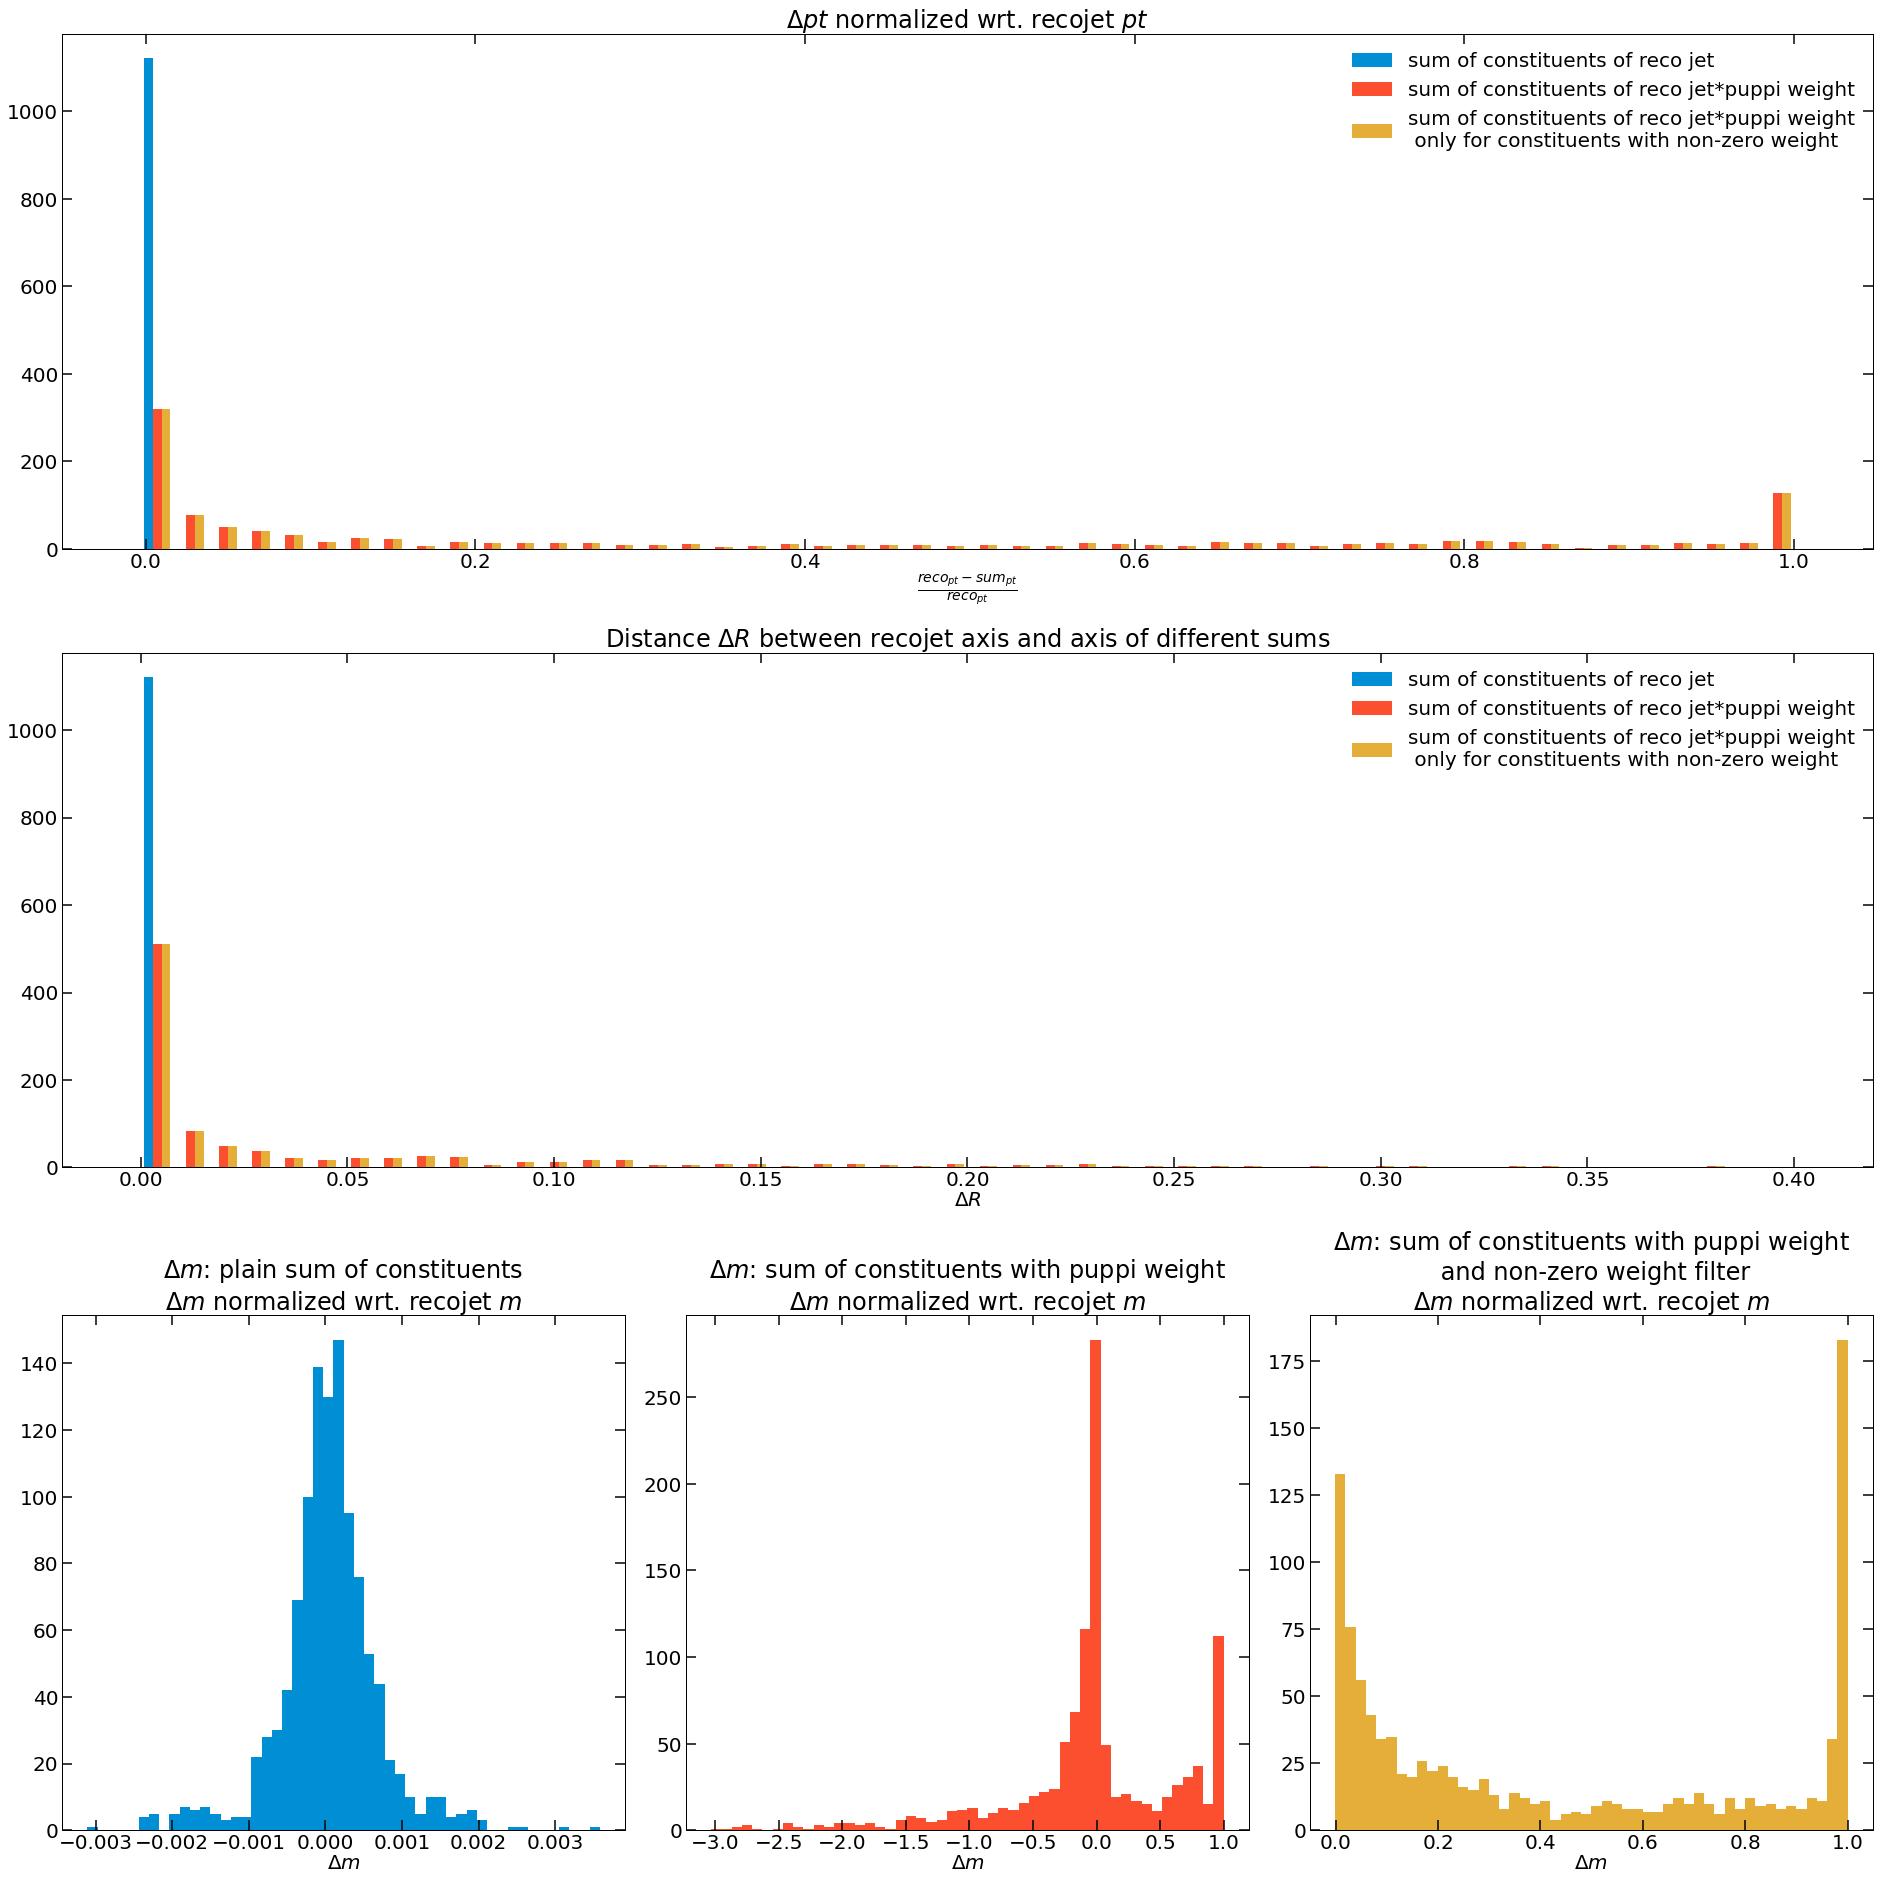

In [5]:
plt.rcParams["figure.figsize"] = (26,26)
plt.rcParams.update({'font.size': 20})

fig = plt.figure(constrained_layout=True)
ax = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(ax[0, 0:3])
ax1.hist([d_pts, d_pts_w, d_pts_wf], bins=50, label=["sum of constituents of reco jet", "sum of constituents of reco jet*puppi weight", "sum of constituents of reco jet*puppi weight\n only for constituents with non-zero weight"])
ax1.set_title("$\Delta pt$ normalized wrt. recojet $pt$")
ax1.set_xlabel("$\\frac{reco_{pt}-sum_{pt}}{reco_{pt}}$")
ax1.legend()


ax2 = fig.add_subplot(ax[1, 0:3])
ax2.hist([d_Rs, d_Rs_w, d_Rs_wf], label=["sum of constituents of reco jet", "sum of constituents of reco jet*puppi weight", "sum of constituents of reco jet*puppi weight\n only for constituents with non-zero weight"], bins=50, range=(0, 0.4))
ax2.set_title("Distance $\Delta R$ between recojet axis and axis of different sums")
ax2.set_xlabel("$\Delta R$")
ax2.legend()


ax3 = fig.add_subplot(ax[2, 0])
ax3.hist(d_mass, bins=50, color='#008fd5')
ax3.set_title("$\Delta m$: plain sum of constituents\n$\Delta m$ normalized wrt. recojet $m$")
ax3.set_xlabel("$\Delta m$")

ax4 = fig.add_subplot(ax[2, 1])
ax4.hist(d_mass_w, bins=50, color='#fc4f30')
ax4.set_title("$\Delta m$: sum of constituents with puppi weight\n$\Delta m$ normalized wrt. recojet $m$")
ax4.set_xlabel("$\Delta m$")

ax5 = fig.add_subplot(ax[2, 2])
ax5.hist(d_mass_wf, bins=50, color='#e5ae38')
ax5.set_title("$\Delta m$: sum of constituents with puppi weight\n and non-zero weight filter\n$\Delta m$ normalized wrt. recojet $m$")
ax5.set_xlabel("$\Delta m$")

plt.show()

fig.savefig("plots/different_4vecsums.pdf")

#### Conclusion
Recojets (with pt and mass scaled by the raw pt factor) are most closely resembled by the plain 4 Vector sum of the constituents. Summing with weighted pt for all PF candidates or only those with a non zero puppi weight leads to identical $\Delta pt$ (run np.allclose(d_pts_w, d_pts_wf)) and $\Delta R$ (max diference is 0; allclose returns False due to NaN values). The former is unsuprising as a particle with $pt=0$ does not contribute to the overall $pt$, causing the two sums to be identical. The later is also expected as the PF candiates with are constituents of a recojet will have a puppi weight close to 1, such that no particles will be removed when applying the puppi_filter.

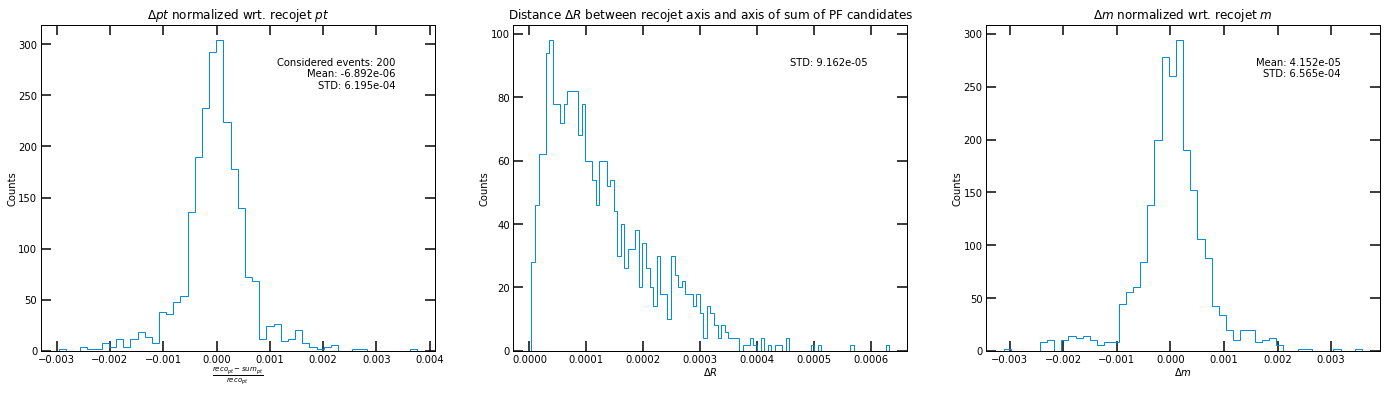

In [8]:
fig, ax = plt.subplots(1,3, figsize=(24,6))
plt.rcParams.update({'font.size': 10})

ax[0].hist(d_pts, bins=50, histtype='step')
ax[0].text(0.9, 0.9, "Considered events: {}\nMean: {:.3e}\nSTD: {:.3e}".format(max_idx, np.mean(d_pts), np.std(d_pts)), ha='right', va='top', transform = ax[0].transAxes)
ax[0].set_title("$\Delta pt$ normalized wrt. recojet $pt$")
ax[0].set_xlabel("$\\frac{reco_{pt}-sum_{pt}}{reco_{pt}}$")
ax[0].set_ylabel("Counts")

content_R = ax[1].hist(d_Rs, bins=100, histtype='step')
ax[1].text(0.9, 0.9, "STD: {:.3e}".format(np.std(d_Rs)), ha='right', va='top', transform = ax[1].transAxes)
ax[1].set_title("Distance $\Delta R$ between recojet axis and axis of sum of PF candidates")
ax[1].set_xlabel("$\Delta R$")
ax[1].set_ylabel("Counts")

ax[2].hist(d_mass, bins=50, histtype='step')
ax[2].text(0.9, 0.9, "Mean: {:.3e}\nSTD: {:.3e}".format(np.mean(d_mass), np.std(d_mass)), ha='right', va='top', transform = ax[2].transAxes)
ax[2].set_title("$\Delta m$ normalized wrt. recojet $m$")
ax[2].set_xlabel("$\Delta m$")
ax[2].set_ylabel("Counts")

plt.show()

fig.savefig("plots/plain_4vectorsum.pdf")